In [3]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt

import torch

In [4]:
path = "/home/danilo/SSD/FGV/"

landsat8_train = path + "landsat8_train/train/"
deforest_train = path + "deforestation_train4/train/"

dst = path + "data6/"

In [5]:
'Landsat8_QA_PIXEL_-54.48_-3.33_2013_03_27.tiff'

def get_name_landsat(row, band):
    return f"Landsat8_{band}_{row['lon']:.2f}_{row['lat']:.2f}_{row['date'].year}_{row['date'].month:02d}_{row['date'].day:02d}.tiff"

images = np.array(os.listdir(landsat8_train))
images.sort()

images = images[:int(images.size/9)]

def get_dict(name):
    tokens = name.split("_")
    
    lat = float(tokens[4])
    lon = float(tokens[3])
    
    y = int(tokens[5])
    m = int(tokens[6])
    d = int(tokens[7].split('.')[0])
    
    return {"date": pd.Timestamp(y, m, d), "lat": lat, "lon": lon}

landsat_df = pd.DataFrame(data = [get_dict(i) for i in images])
landsat_df

,date,lat,lon
0,2013-03-27,-3.33,-54.48
1,2013-05-20,-3.33,-54.48
2,2013-06-05,-3.33,-54.48
3,2013-06-21,-3.33,-54.48
4,2013-07-07,-3.33,-54.48
...,...,...,...
233220,2021-08-14,-4.39,-55.20
233221,2021-09-15,-4.39,-55.20
233222,2021-10-01,-4.39,-55.20
233223,2021-10-17,-4.39,-55.20


In [6]:
'Deforestation_-54.48_-3.35_2016_08_01.tiff'

def get_name_deforestation(row):
    return f"Deforestation_{row['lon']:.2f}_{row['lat']:.2f}_{row['date'].year}_{row['date'].month:02d}_{row['date'].day:02d}.tiff"

images = np.array(os.listdir(deforest_train))
images.sort()

def get_dict(name):
    tokens = name.split("_")
    
    lat = float(tokens[2])
    lon = float(tokens[1])
    
    y = int(tokens[3])
    m = int(tokens[4])
    d = int(tokens[5].split('.')[0])
    
    return {"date": pd.Timestamp(y, m, d), "lat": lat, "lon": lon}

deforest_df = pd.DataFrame(data = [get_dict(i) for i in images])
deforest_df

,date,lat,lon
0,2016-08-01,-3.35,-54.48
1,2017-07-01,-3.35,-54.48
2,2017-08-01,-3.35,-54.48
3,2018-06-01,-3.35,-54.48
4,2018-08-01,-3.35,-54.48
...,...,...,...
17210,2019-08-01,-4.39,-55.20
17211,2020-06-01,-4.39,-55.20
17212,2020-08-01,-4.39,-55.20
17213,2021-05-01,-4.39,-55.20


In [7]:
landsat_df["date"].min()

Timestamp('2013-03-27 00:00:00')

date    2016-08-01 00:00:00
lat                   -3.47
lon                   -54.5
Name: 660, dtype: object
(85, 85)


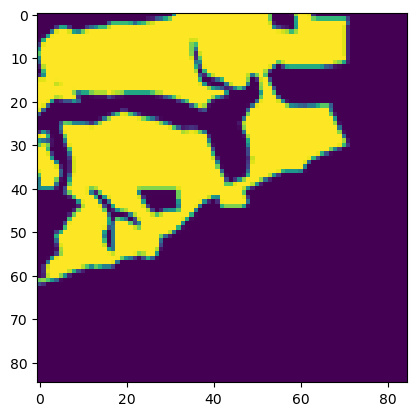

In [8]:
def load_labels(img):
    img = Image.open(img)
    img = np.array(img).astype(np.float32) / 256
    return img

lab = None
j = None
for i, j in deforest_df.iterrows():
    name = get_name_deforestation(j)
    lab = load_labels(deforest_train + name)
    if lab.mean() > 0.3:
        break

print(j)
print(lab.shape)
plt.imshow(lab);

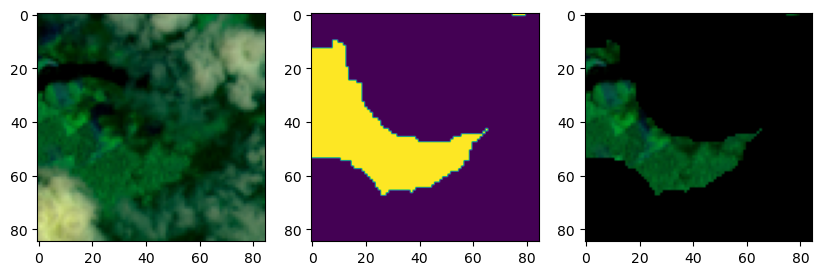

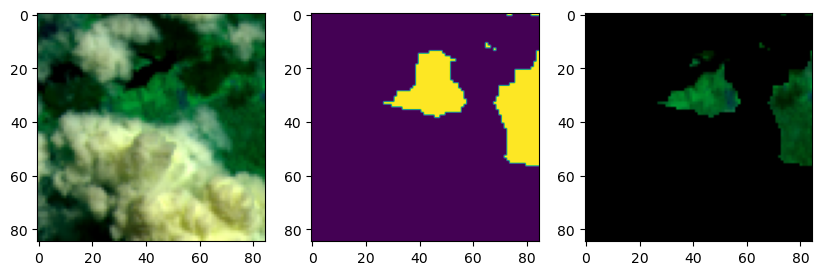

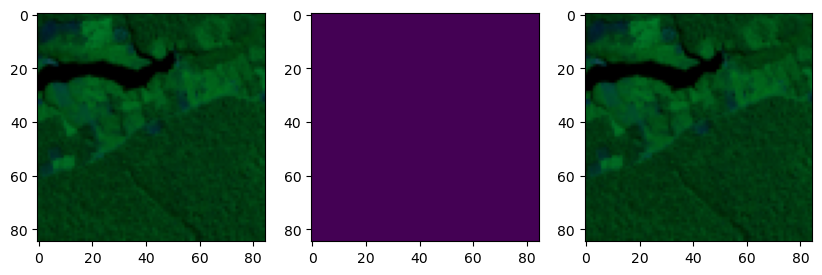

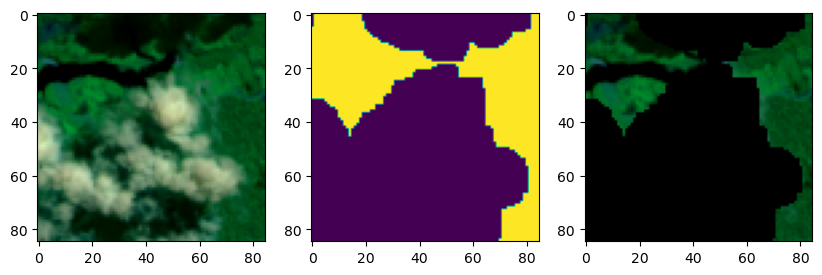

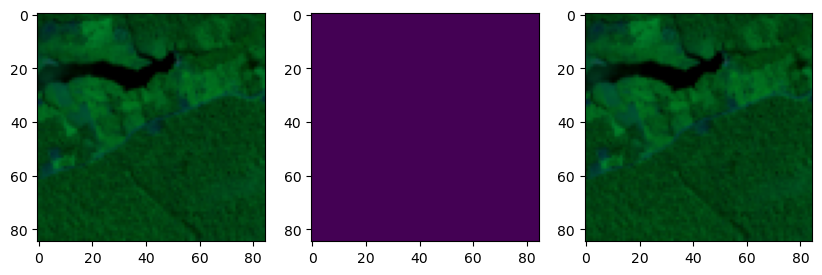

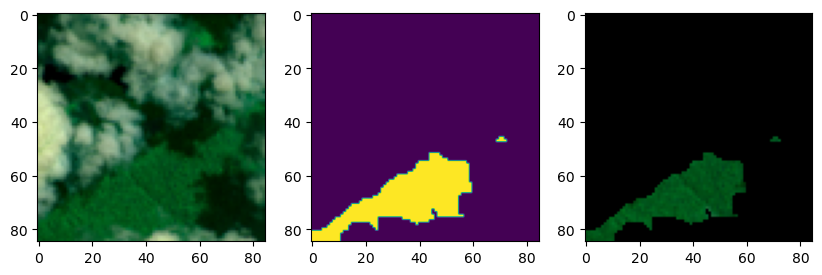

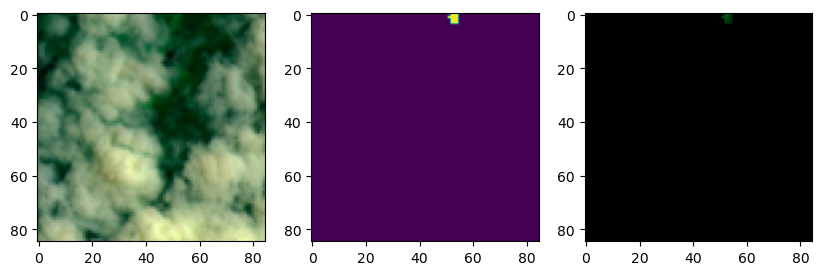

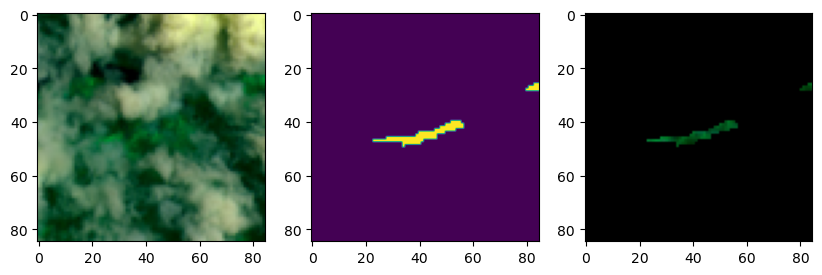

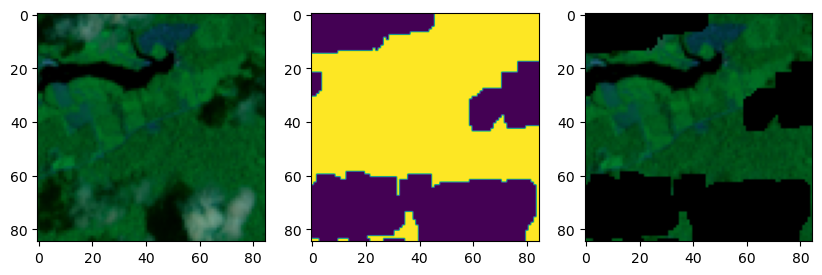

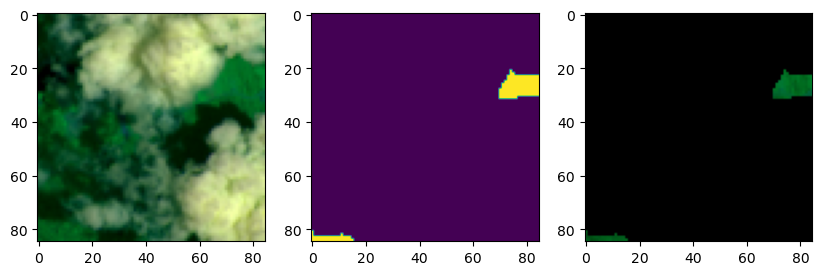

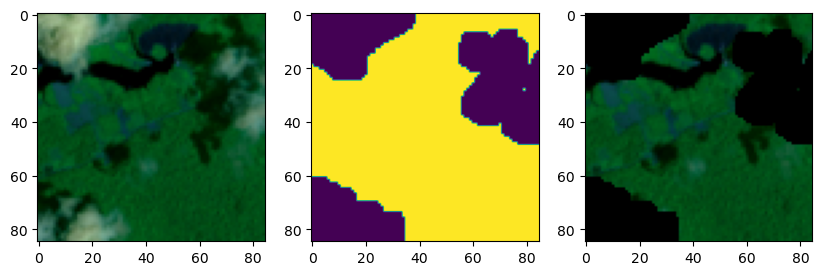

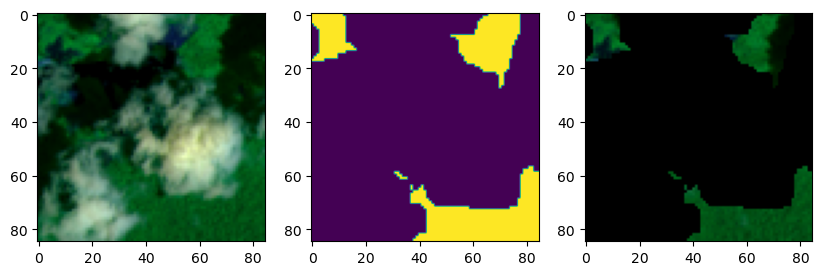

In [9]:
# Mostrando imagens de um único ponto e o filtro de núvens

def load_image(img):
    i = Image.open(img)
    i = np.array(i).astype(np.float32)

    #i -= i.min()
    #if i.max() != 0:
    #    i /= i.max()
    i -= 10000
    i /= 35000
    
    return i

def load_qa(img):
    # https://www.usgs.gov/landsat-missions/landsat-collection-1-level-1-quality-assessment-band
    i = Image.open(img)
    i = (np.array(i) & 0b11111) == 0
    i = i.astype(np.float32)
    return i

(lat, lon) = (j["lat"], j["lon"])

ll = landsat_df[(landsat_df["lat"] == lat) & (landsat_df["lon"] == lon)]
ll = ll.sort_values(by = "date")

for i in range(12):
    lr = ll.iloc[i]
    
    images = []
    # [ "SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B6", "SR_B7", "ST_B10", "QA_PIXEL" ]
    for band in ["SR_B4", "SR_B5", "SR_B6"]:
        name = get_name_landsat(lr, band)
        images.append(load_image(landsat8_train + name))
    img = np.stack(images, axis = -1)
    qa = load_qa(landsat8_train + get_name_landsat(lr, "QA_PIXEL"))

    # plot three images horizontally
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    axes[0].imshow(img.clip(0,1))
    axes[1].imshow(qa)
    axes[2].imshow(img.clip(0,1) * qa[:, :, np.newaxis]);

In [12]:
# Para cada label, cria a imagem com média ponderada e salva

def get_image_and_qa(lr):

    bands = []
    # [ "SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B6", "SR_B7", "ST_B10", "QA_PIXEL" ]
    for band in [ "SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B6", "SR_B7"]:
        name = get_name_landsat(lr, band)
        bands.append(load_image(landsat8_train + name))
    img = np.stack(bands, axis = -1)
    qa = load_qa(landsat8_train + get_name_landsat(lr, "QA_PIXEL"))
    
    return img, qa

# iterate over deforestation images
for i, j in tqdm(deforest_df.iterrows(), total = deforest_df.shape[0]):
    name = get_name_deforestation(j)
    lab = load_labels(deforest_train + name)

    # Get all images from the same location
    (lat, lon) = (j["lat"], j["lon"])
    ll = landsat_df[(landsat_df["lat"] == lat) & (landsat_df["lon"] == lon)] 
    ll = ll.sort_values(by = "date").reset_index(drop = True) # Sort by date

    # Get the closest image to the deforestation
    time_diff = ll["date"] - j["date"]
    idx = time_diff[time_diff > pd.Timedelta(0)].idxmin()

    # Get the 12 images before and after the deforestation
    image = None
    rg = 12
    C = [] # [0, -1, 1, -2, 2, -3, 3, ...]
    for a, b in zip(range(rg), range(-1, -rg, -1)):
        C.append(a)
        C.append(b)
    for i in C:
        try:
            lr = ll.iloc[idx + i]
        except:
            continue
        img, qa = get_image_and_qa(lr)
        if qa.mean() >= 0.8:
            image = img
            break
    else:
        # this will be called if the loop ended without break
        print("AAAAA")
        continue

    # upsample images with torch
    image = torch.tensor(image)
    lab = torch.tensor(lab)[:, :, None]
    
    #append lab to images
    image = torch.cat([image, lab], dim=2)
    image = image.numpy()
    
    # save image
    mean = lab.mean()
    name = f"Labeled_{j['lat']:.2f}_{j['lon']:.2f}_{j['date'].year}_{j['date'].month:02d}_{j['date'].day:02d}_{mean:.2f}.npy"
    np.save(dst + name, image)

  0%|          | 0/17215 [00:00<?, ?it/s]

 24%|██▍       | 4191/17215 [01:06<04:25, 49.12it/s]

AAAAA


 31%|███       | 5351/17215 [01:25<04:32, 43.55it/s]

AAAAA


 31%|███       | 5363/17215 [01:26<05:10, 38.22it/s]

AAAAA


 35%|███▍      | 5946/17215 [01:35<03:14, 57.83it/s]

AAAAA


 35%|███▍      | 5959/17215 [01:35<03:36, 51.91it/s]

AAAAA


 38%|███▊      | 6542/17215 [01:45<03:05, 57.61it/s]

AAAAA


 38%|███▊      | 6556/17215 [01:45<03:47, 46.78it/s]

AAAAA


 41%|████▏     | 7132/17215 [01:54<03:06, 54.21it/s]

AAAAA
AAAAA


 42%|████▏     | 7147/17215 [01:54<03:09, 53.17it/s]

AAAAA


 42%|████▏     | 7170/17215 [01:55<03:14, 51.67it/s]

AAAAA


 42%|████▏     | 7176/17215 [01:55<04:01, 41.62it/s]

AAAAA


 42%|████▏     | 7187/17215 [01:55<04:31, 36.94it/s]

AAAAA
AAAAA


 49%|████▉     | 8518/17215 [02:16<02:47, 51.95it/s]

AAAAA


 52%|█████▏    | 8954/17215 [02:22<02:25, 56.76it/s]

AAAAA


 53%|█████▎    | 9082/17215 [02:24<02:32, 53.25it/s]

AAAAA
AAAAA


 80%|████████  | 13836/17215 [03:38<01:08, 49.45it/s]

AAAAA
AAAAA


 90%|████████▉ | 15447/17215 [04:02<00:31, 55.92it/s]

AAAAA


100%|██████████| 17215/17215 [04:32<00:00, 63.26it/s]


In [ ]:
# TODO - get the last three with clouds < 0.x

dst = path + "triple_data/"

def get_image_and_qa2(lr):
    bands = []
    # [ "SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B6", "SR_B7", "ST_B10", "QA_PIXEL" ]
    for band in [ "SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B6", "SR_B7"]:
        name = get_name_landsat(lr, band)
        bands.append(load_image(landsat8_train + name))
    img = np.stack(bands, axis = -1)
    qa = load_qa(landsat8_train + get_name_landsat(lr, "QA_PIXEL"))
    
    # img shape: (85, 85, 7)
    # qa shape: (85, 85)
    return np.concatenate([img, qa[:, :, None]], axis = -1)

# iterate over deforestation images
for i, j in tqdm(deforest_df.iterrows(), total = deforest_df.shape[0]):
    name = get_name_deforestation(j)
    lab = load_labels(deforest_train + name)[:, :, None]

    # Get all images from the same location
    (lat, lon) = (j["lat"], j["lon"])
    ll = landsat_df[(landsat_df["lat"] == lat) & (landsat_df["lon"] == lon)] 
    ll = ll.sort_values(by = "date").reset_index(drop = True) # Sort by date

    # Get the closest image to the deforestation
    time_diff = ll["date"] - j["date"]
    idx = time_diff[time_diff > pd.Timedelta(0)].idxmin()

    # Get the images before and after the deforestation
    image = get_image_and_qa2(ll.iloc[idx])

    im0 = image
    try:
        lr = ll.iloc[idx - 1]
        im0 = get_image_and_qa2(lr)
    except:
        pass

    im1 = image
    try:
        lr = ll.iloc[idx - 2]
        im1 = get_image_and_qa2(lr)
    except:
        continue

    image = np.concatenate([im1, im0, image, lab], axis = -1)

    # save image
    name = f"Labeled_{j['lat']:.2f}_{j['lon']:.2f}_{j['date'].year}_{j['date'].month:02d}_{j['date'].day:02d}_{0.0}.npy"
    np.save(dst + name, image)